In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

In [2]:
def read_data(filename):
    data = pd.read_csv(filename, na_values=['-nan(ind)', ' -nan(ind)'])
    data = data.astype({
        'a1': float,
        ' a2': float,
        ' Average Total Energy [K]': float,
        ' Standard Deviation [K]': float,
        ' Energy per particle [erg]': float
    })
    if " -nan(ind)" in data.values:
        print(f"Warning: NaN values found in {filename}")
    data.rename(columns={
        'a1': 'a1',
        ' a2': 'a2',
        ' Average Total Energy [K]': 'Et [K]',
        ' Standard Deviation [K]': 'std [K]',
        ' Energy per particle [erg]': 'e [erg]'
    }, inplace=True)

    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    data["std [erg]"] = data["std [K]"] * 1.380649e-16/200 # Kb* erg/J /Np

    return data

# GPU-powered Variational Monte Carlo simulations for the ground state of liquid $He^4$

# Import data
Data were extrapolated from the paper using [WebPlotDigitizer](https://automeris.io/wpd/) so small discrepancies are expected.

In [3]:
McMillan65_data = pd.read_csv("ref/McMillan65_data.csv")
McMillan65_data.sort_values(by='a1 [ang]', inplace=True)

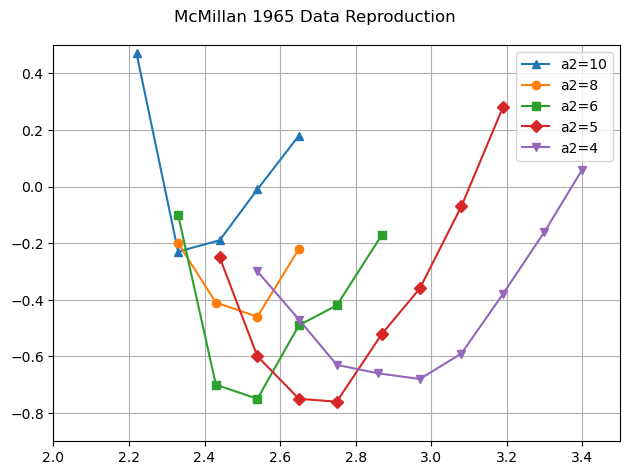

In [4]:
%matplotlib inline
fig, ax = plt.subplots()

fig.suptitle("McMillan 1965 Data Reproduction")

markers = {10: "^", 8: "o", 6: "s", 5: "D", 4: "v"}
groups = {t: [] for t in markers.keys()}

for (a1, a2, E) in McMillan65_data.values:
    for t in markers.keys():
        if np.isclose(a2, t):
            groups[t].append((a1, E))
            break

for t in markers.keys():
    xs, ys = zip(*groups[t])
    ax.plot(xs, ys, marker=markers[t], label=f"a2={t}")


ax.set_xlim(2, 3.5)
ax.set_ylim(-0.9, 0.5)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Read all the simulated data 

In [5]:
data = pd.DataFrame()

data = pd.concat([data, read_data('coarse_grid_ave_energy200.csv')], ignore_index=True)
data = pd.concat([data, read_data('fine_grid_ave_energy200.csv')], ignore_index=True)
data = pd.concat([data, read_data('finer_grid_ave_energy200.csv')], ignore_index=True)
data = pd.concat([data, read_data('McMillan_minimum.csv')], ignore_index=True)
data = pd.concat([data, read_data('smaller_error.csv')], ignore_index=True)

data.head()

,a1,a2,Et [K],std [K],e [erg],std [erg]
0,2.1,3.5,12750.970,9278.299,8.798170e-15,6.405037e-15
1,2.1,4.0,8302.885,6006.381,5.728991e-15,4.146352e-15
2,2.1,4.5,5833.316,3763.591,4.024988e-15,2.598099e-15
3,2.1,5.0,4249.053,2865.094,2.931846e-15,1.977845e-15
4,2.1,5.5,3567.239,2382.123,2.461395e-15,1.644438e-15


Plot the data in $10^{-15} erg$

In [6]:
x = data["a1"].values
y = data["a2"].values
z = data["e [erg]"].values *1e15
err = data["std [erg]"].values *1e15

In [7]:
idx = np.argmin(z)

Emin = z[idx]
errmin = err[idx]
a1min = x[idx]
a2min = y[idx]
print(f"Minimum energy per particle: {Emin:.3f}+-{errmin:.3f} x10^{-15} erg at a1={a1min:.3f}, a2={a2min:.3f}")

Minimum energy per particle: -0.771+-0.283 x10^-15 erg at a1=2.670, a2=4.600


In [8]:
# At the top of your notebook
%matplotlib qt

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot triangulated surface and error bars
ax.plot_trisurf(x, y, z, cmap='viridis', alpha=0.8, edgecolor='none')
ax.errorbar(x, y, z, zerr=err, fmt='o', color='k', ecolor='lightgray', elinewidth=1, capsize=2, markersize=0)

# Plot McMillan65 data points
ax.plot(McMillan65_data.values[:,0], McMillan65_data.values[:,1], McMillan65_data.values[:,2], 'ro')

# Plot the minimum point
ax.scatter(a1min, a2min, Emin, color='r', s=100, label=fr'Fit Minimum: ${Emin:.2f}\pm{errmin:.2f}\times10^{{-15}}$ erg at $a_1$={a1min:.3f}, $a_2$={a2min:.3f}', marker='X')

ax.set_xlabel(r'$a_1$')
ax.set_ylabel(r'$a_2$')
ax.set_zlabel(r'Energy per particle [$10^{15}$erg]')
ax.view_init(elev=30, azim=-20)

ax.legend()

fig.tight_layout()
#fig.savefig("../plots/AllPoints.png", dpi=500)
fig.show()


In [9]:
# At the top of your notebook
%matplotlib qt

xlim = (2.5, 2.7)
ylim = (4, 6.0)

mask = (x >= xlim[0]) & (x <= xlim[1]) & (y >= ylim[0]) & (y <= ylim[1])
plot_x = x[mask]
plot_y = y[mask]
plot_z = z[mask]
plot_err = err[mask]


# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot triangulated surface and error bars
ax.plot_trisurf(plot_x, plot_y, plot_z, cmap='viridis', alpha=0.8, edgecolor='none')
ax.errorbar(plot_x, plot_y, plot_z, zerr=plot_err, fmt='o', color='k', ecolor='lightgray', elinewidth=1, capsize=2, markersize=0)

# Plot the surface of the minima

# Plot McMillan65 data points
McMillanInRange = McMillan65_data[
    (McMillan65_data['a1 [ang]'] >= xlim[0]) &
    (McMillan65_data['a1 [ang]'] <= xlim[1]) &
    (McMillan65_data[' a2'] >= ylim[0]) &
    (McMillan65_data[' a2'] <= ylim[1])
]
ax.plot(McMillanInRange.values[:,0], McMillanInRange.values[:,1], McMillanInRange.values[:,2], 'ro')


ax.set_xlabel(r'$a_1$')
ax.set_ylabel(r'$a_2$')
ax.set_zlabel(r'Energy per particle [$10^{15}$erg]')


fig.tight_layout()
plt.show()

## Paraboloid fit around the minima

In [10]:
data = pd.DataFrame()

data = pd.concat([data, read_data('fine_grid_ave_energy200.csv')], ignore_index=True)
data = pd.concat([data, read_data('finer_grid_ave_energy200.csv')], ignore_index=True)
data = pd.concat([data, read_data('McMillan_minimum.csv')], ignore_index=True)
data = pd.concat([data, read_data('smaller_error.csv')], ignore_index=True)

data.head()

,a1,a2,Et [K],std [K],e [erg],std [erg]
0,2.4,4.0,719.42140,1677.231,4.964008e-16,1.157834e-15
1,2.4,4.1,485.27020,1542.018,3.348364e-16,1.064493e-15
2,2.4,4.2,340.47170,1404.824,2.349255e-16,9.697844e-16
3,2.4,4.3,261.91380,1310.152,1.807205e-16,9.044300e-16
4,2.4,4.4,85.36689,1247.365,5.890316e-17,8.610866e-16


In [11]:
x = data["a1"].values
y = data["a2"].values
z = data["e [erg]"].values *1e15
err = data["std [erg]"].values *1e15

In [33]:
def paraBolEqn(data,a,b,c,d, e):
    x,y = data
    return (((x-b)/a)**2+((y-d)/c)**2)+e

def sigma_paraBolEqn(data, a, b, c, d, e, sigma_a, sigma_b, sigma_c, sigma_d, sigma_e):
    x, y = data
    f = ((x-b)/a)**2 + ((y-d)/c)**2 + e

    # partial derivatives
    df_da = -2*(x-b)**2 / a**3
    df_db = -2*(x-b) / a**2
    df_dc = -2*(y-d)**2 / c**3
    df_dd = -2*(y-d) / c**2
    df_de = 1

    # contributions from each parameter
    contrib_a = (df_da * sigma_a)**2
    contrib_b = (df_db * sigma_b)**2
    contrib_c = (df_dc * sigma_c)**2
    contrib_d = (df_dd * sigma_d)**2
    contrib_e = (df_de * sigma_e)**2

    # total propagated error
    sigma_f = (contrib_a + contrib_b + contrib_c + contrib_d + contrib_e)**0.5

    return sigma_f



xy = np.vstack((x,y))
p0 = [0.1, a1min, 0.1, a2min, Emin]
popt, pcov=opt.curve_fit(paraBolEqn, xy, z, sigma=err, absolute_sigma=True, maxfev=100000)

# get error estimates for the parameters
perr = np.sqrt(np.diag(pcov))
print("Fitted parameters:")
print(f"curv_a1: {popt[0]:.2f} ± {perr[0]:.2f}")
print(f"a1: {popt[1]:.2f} ± {perr[1]:.2f}")
print(f"curv_a2: {popt[2]:.2f} ± {perr[2]:.2f}")
print(f"a2: {popt[3]:.2f} ± {perr[3]:.2f}")
print(f"Emin: {popt[4]:.2f} ± {perr[4]:.2f}")

Fitted parameters:
curv_a1: 0.37 ± 0.04
a1: 2.59 ± 0.01
curv_a2: 2.45 ± 0.30
a2: 5.14 ± 0.07
Emin: -0.73 ± 0.02


In [13]:
# Get fitted minimum and its location with error estimates
XY_mesh = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))

zfit = paraBolEqn(XY_mesh, *popt)
Emin_fit_idx = np.unravel_index(zfit.argmin(), zfit.shape)
Emin_fit = zfit[Emin_fit_idx]
a1min_fit = XY_mesh[0][Emin_fit_idx]
a2min_fit = XY_mesh[1][Emin_fit_idx]
err_Emin_fit = sigma_paraBolEqn((a1min_fit, a2min_fit), *popt, *perr)
print(f"Fitted minimum energy per particle: {Emin_fit:.2f}+-{err_Emin_fit:.2f} x10^-15 erg at a1={a1min_fit:.3f}, a2={a2min_fit:.3f}")

Fitted minimum energy per particle: -0.73+-0.02 x10^-15 erg at a1=2.591, a2=5.152


In [14]:
# draw the fit result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(x, y, paraBolEqn((x, y), *popt), cmap='plasma', alpha=0.4, edgecolor='none')
ax.errorbar(x, y, z, zerr=err, fmt='o', color='k', ecolor='lightgray', elinewidth=1, capsize=2, markersize=0)

ax.scatter(a1min_fit, a2min_fit, Emin_fit, color='r', s=100, label=fr'Fit Minimum: ${Emin_fit:.2f}\pm{err_Emin_fit:.2f}\times10^{{-15}}$ erg at $a_1$={a1min_fit:.3f}, $a_2$={a2min_fit:.3f}', marker='X')


ax.set_xlabel(r'$a_1$')
ax.set_ylabel(r'$a_2$')
ax.set_zlabel(r'Fitted Energy per particle [$10^{15}$erg]')
ax.view_init(elev=30, azim=-20)
ax.legend()

fig.tight_layout()
#fig.savefig("../plots/ParaboloidFit.png", dpi=500)
fig.show()